In [1]:
# --------------------------------------------------------------------------------
# Install required library for reading Physionet waveforms
# --------------------------------------------------------------------------------
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 71.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.5 which is 

In [2]:
# --------------------------------------------------------------------------------
# Necessary imports
# --------------------------------------------------------------------------------
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import detrend
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import gc

In [3]:
# --------------------------------------------------------------------------------
# Optional: Set mixed precision policy for performance on modern GPUs
# --------------------------------------------------------------------------------
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [4]:
# --------------------------------------------------------------------------------
# Enable dynamic memory growth on available GPUs
# --------------------------------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Dynamic GPU memory growth is enabled.")
    except RuntimeError as e:
        print(e)

Dynamic GPU memory growth is enabled.


In [5]:
# --------------------------------------------------------------------------------
# BatchLoader class to load data in batches from .dat files
# --------------------------------------------------------------------------------
class BatchLoader:
    """
    This class reads all .dat files in a given directory, extracts 
    the 'HR' (heart rate) signal, normalizes, detrends, and splits 
    the data into windows of specified size. Each call returns a 
    batch of data for training the models.
    """
    def __init__(self, data_dir, batch_size, window_size, max_duration_hours, sample_rate=100):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.window_size = window_size
        self.max_samples = int(max_duration_hours * 60 * 60 * sample_rate)
        self.files = sorted([f for f in os.listdir(data_dir) if f.endswith(".dat")])

    def __len__(self):
        """
        Calculates the total number of batches based on 
        maximum duration and window size across all files.
        """
        total_samples = 0
        for file in self.files:
            signals, _ = wfdb.rdsamp(os.path.join(self.data_dir, os.path.splitext(file)[0]))
            total_samples += min(signals.shape[0], self.max_samples)
        return int(total_samples // (self.batch_size * self.window_size))

    def __getitem__(self, idx):
        """
        Returns a single batch of data. It reads the next batch_size windows
        (of length window_size) from the files, normalizes and detrends them.
        """
        start_idx = idx * self.batch_size
        batch_data = []
        for file in self.files:
            file_path = os.path.join(self.data_dir, os.path.splitext(file)[0])
            signals, fields = wfdb.rdsamp(file_path)
            signal_names = fields['sig_name']

            # Only proceed if 'HR' signal is found
            if "HR" in signal_names:
                hr_index = signal_names.index("HR")
                hr_signal = signals[:, hr_index]

                # Limit to maximum samples if needed
                if len(hr_signal) > self.max_samples:
                    hr_signal = hr_signal[:self.max_samples]

                # Interpolate missing values
                hr_signal = pd.Series(hr_signal).interpolate(method='linear').bfill().ffill().values

                # Normalize between [0, 1] and detrend
                normalized_signal = (hr_signal - np.min(hr_signal)) / (np.max(hr_signal) - np.min(hr_signal))
                detrended_signal = detrend(normalized_signal)

                # Split into windows
                num_windows = len(detrended_signal) // self.window_size
                windows = [
                    detrended_signal[i * self.window_size:(i + 1) * self.window_size]
                    for i in range(num_windows)
                ]
                batch_data.extend(windows)
                if len(batch_data) >= self.batch_size:
                    break

        # Ensure the batch is exactly batch_size
        batch_data = batch_data[:self.batch_size]

        # Return batch as a 3D tensor: (batch, window_size, 1)
        return np.expand_dims(np.array(batch_data), axis=-1)


In [6]:
# --------------------------------------------------------------------------------
# Create an instance of the BatchLoader
# --------------------------------------------------------------------------------
data_dir = "/kaggle/input/stress-recognition-in-automobile-drivers/physionet.org/files/drivedb/1.0.0/"
batch_size = 512
window_size = 100
max_duration_hours = 0.1

loader = BatchLoader(data_dir, batch_size, window_size, max_duration_hours)
print("Batch loader initialized.")

Batch loader initialized.


In [7]:
# --------------------------------------------------------------------------------
# Build generator model
# --------------------------------------------------------------------------------
def build_generator(window_size):
    """
    Builds the Generator model which takes random noise (or any seed input)
    of shape (window_size, 1) and outputs a (window_size, 1) signal.
    """
    gen_input = Input(shape=(window_size, 1))
    x = LSTM(512, activation=None, return_sequences=True)(gen_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = LSTM(256, activation=None, return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    
    gen_output = Dense(1, activation='linear')(x)
    generator = Model(inputs=gen_input, outputs=gen_output, name="Generator")
    return generator

# --------------------------------------------------------------------------------
# Build discriminator model
# --------------------------------------------------------------------------------
def build_discriminator(window_size):
    """
    Builds the Discriminator model which receives a (window_size, 1) signal
    and outputs a single scalar (real/fake decision).
    """
    disc_input = Input(shape=(window_size, 1))
    x = LSTM(64, activation='tanh', return_sequences=True)(disc_input)
    x = Dropout(0.3)(x)
    x = LSTM(32, activation='tanh', return_sequences=False)(x)
    x = Dense(16)(x)
    x = LeakyReLU(alpha=0.2)(x)
    disc_output = Dense(1, activation='linear')(x)  # Linear output for WGAN-type
    discriminator = Model(inputs=disc_input, outputs=disc_output, name="Discriminator")
    return discriminator

# Instantiate generator and discriminator
generator = build_generator(window_size)
discriminator = build_discriminator(window_size)

# Compile discriminator
discriminator.compile(
    optimizer=Adam(learning_rate=0.00005, beta_1=0.5, beta_2=0.9, clipvalue=1.0),
    loss='binary_crossentropy'
)

# --------------------------------------------------------------------------------
# Build GAN by stacking generator and discriminator
# --------------------------------------------------------------------------------
def build_gan(generator, discriminator):
    """
    Freezes the discriminator weights (so only generator learns)
    and connects generator -> discriminator (output).
    """
    discriminator.trainable = False
    gan_input = Input(shape=(window_size, 1))
    gen_output = generator(gan_input)
    gan_disc_output = discriminator(gen_output)
    gan = Model(inputs=gan_input, outputs=gan_disc_output, name="GAN")
    gan.compile(
        optimizer=Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9, clipvalue=1.0),
        loss='binary_crossentropy'
    )
    return gan



gan = build_gan(generator, discriminator)

# Print summaries (optional)
#generator.summary()
#discriminator.summary()
#gan.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
# --------------------------------------------------------------------------------
# Training loop
# --------------------------------------------------------------------------------
epochs = 160            # Number of epochs to train
steps_per_epoch = len(loader)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    d_losses, g_losses = [], []

    # Iterate over all steps in one epoch
    for step in range(steps_per_epoch):
        print(f"Step {step + 1}/{steps_per_epoch}", end="\r")

        # 1) Load real data batch
        real_data = loader[step]
        if real_data.shape[0] == 0:
            continue  # Skip if no data returned
        real_labels = np.ones((real_data.shape[0], 1))

        # 2) Generate fake data batch
        noise = np.random.normal(0, 1, (batch_size, window_size, 1))
        fake_data = generator.predict(noise, verbose=0)
        fake_labels = np.zeros((batch_size, 1))

        # 3) Train the discriminator on real and fake
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_losses.append(d_loss)

        # 4) Train the generator (via the combined model)
        discriminator.trainable = False
        # Target labels for generator training can be set > 0 if using certain GAN variants;
        # here we use -np.ones(...) to align with the code's intention. 
        # You can also use np.ones(...) in standard GAN.
        noise = np.random.normal(0, 1, (batch_size, window_size, 1))
        g_loss = gan.train_on_batch(noise, -np.ones((batch_size, 1)))
        g_losses.append(g_loss)

    # Print losses at the end of each epoch
    print(f"Discriminator Loss: {np.mean(d_losses):.4f}")
    print(f"Generator Loss: {np.mean(g_losses):.4f}")

    # Clear memory (optional)
    gc.collect()
    K.clear_session()


Epoch 1/160


I0000 00:00:1737674888.939211     103 service.cc:145] XLA service 0x56def38151f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737674888.939272     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1737674889.611087     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Discriminator Loss: 6.4010
Generator Loss: 5.9211
Epoch 2/160
Discriminator Loss: 5.3249
Generator Loss: 5.2478
Epoch 3/160
Discriminator Loss: 4.0746
Generator Loss: 4.0404
Epoch 4/160
Discriminator Loss: 3.4327
Generator Loss: 3.4124
Epoch 5/160
Discriminator Loss: 3.0260
Generator Loss: 3.0122
Epoch 6/160
Discriminator Loss: 2.7359
Generator Loss: 2.7258
Epoch 7/160
Discriminator Loss: 2.5125
Generator Loss: 2.5047
Epoch 8/160
Discriminator Loss: 2.3309
Generator Loss: 2.3247
Epoch 9/160
Discriminator Loss: 2.1772
Generator Loss: 2.1721
Epoch 10/160
Discriminator Loss: 2.0441
Generator Loss: 2.0399
Epoch 11/160
Discriminator Loss: 1.9269
Generator Loss: 1.9234
Epoch 12/160
Discriminator Loss: 1.8222
Generator Loss: 1.8192
Epoch 13/160
Discriminator Loss: 1.7280
Generator Loss: 1.7255
Epoch 14/160
Discriminator Loss: 1.6405
Generator Loss: 1.6384
Epoch 15/160
Discriminator Loss: 1.5596
Generator Loss: 1.5578
Epoch 16/160
Discriminator Loss: 1.4808
Generator Loss: 1.4791
Epoch 17/160


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


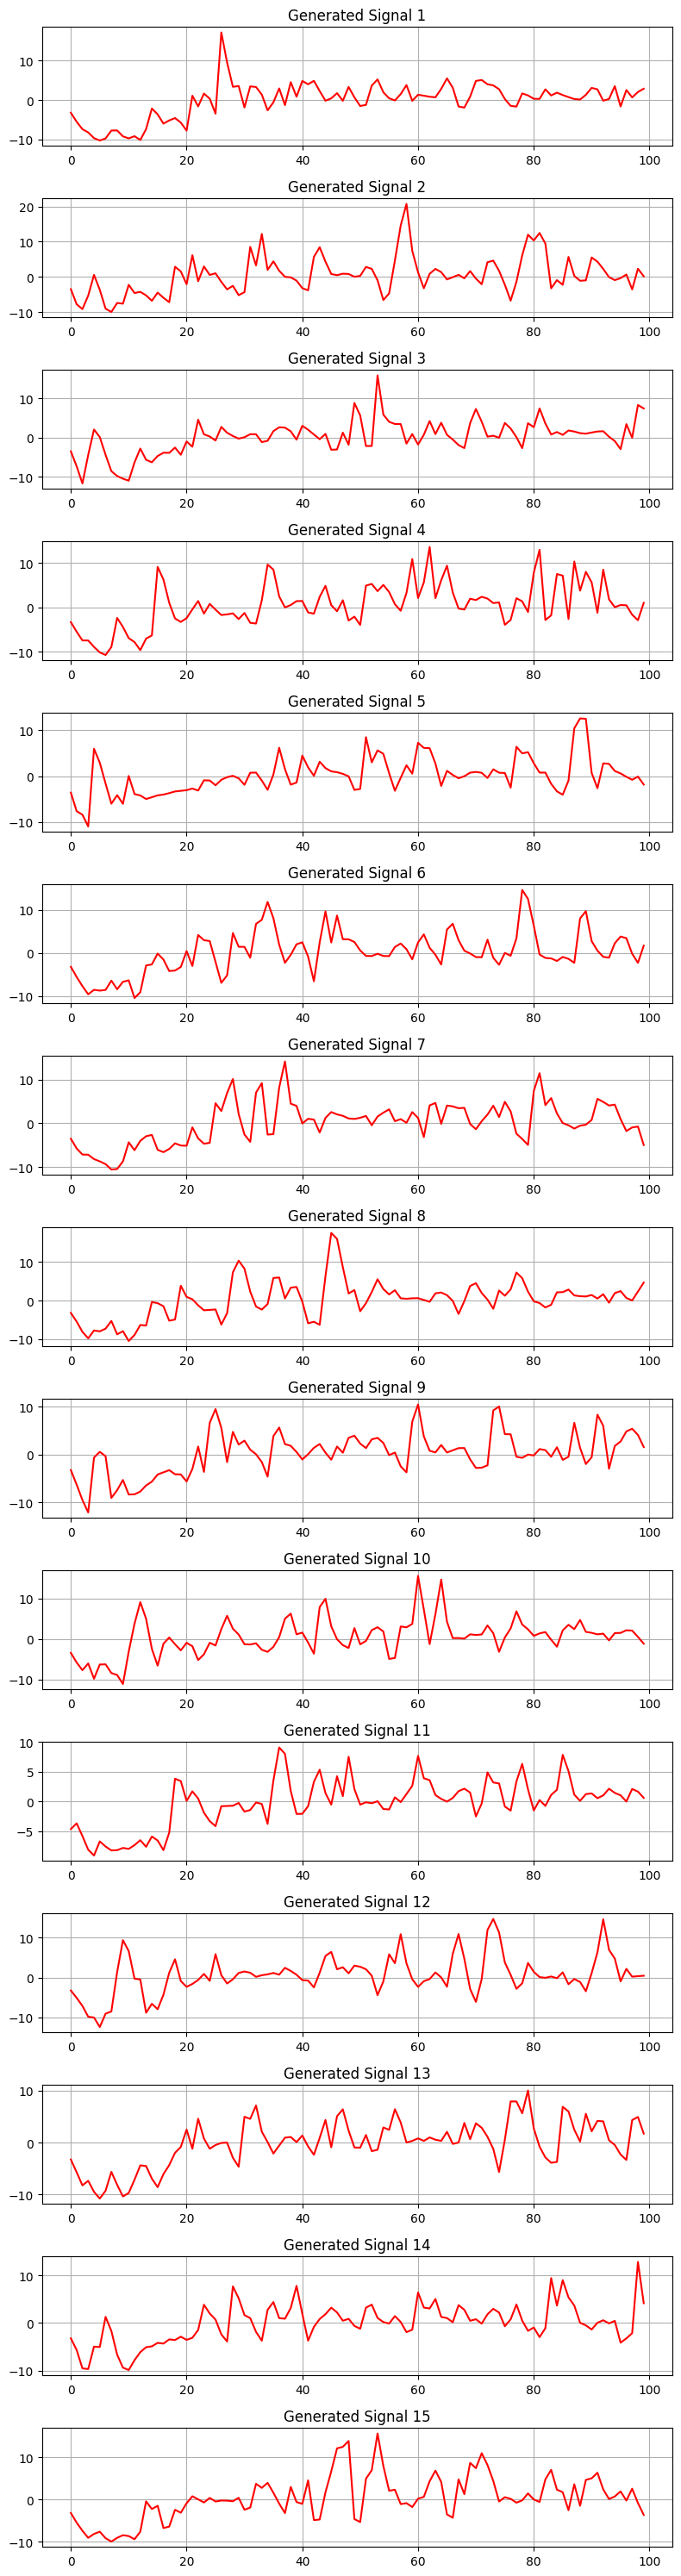

In [12]:
# Number of new signals to generate
num_new_samples = 15

# Generate random noise
noise = np.random.normal(0, 1, (num_new_samples, window_size, 1))

# Predict (generate) signals from the noise
generated_signals = generator.predict(noise)

# Plot the generated signals in a single column of subplots
fig, axes = plt.subplots(nrows=num_new_samples, ncols=1, figsize=(8, 2 * num_new_samples))

for i in range(num_new_samples):
    axes[i].plot(generated_signals[i].squeeze(), color='red')
    axes[i].set_title(f"Generated Signal {i+1}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


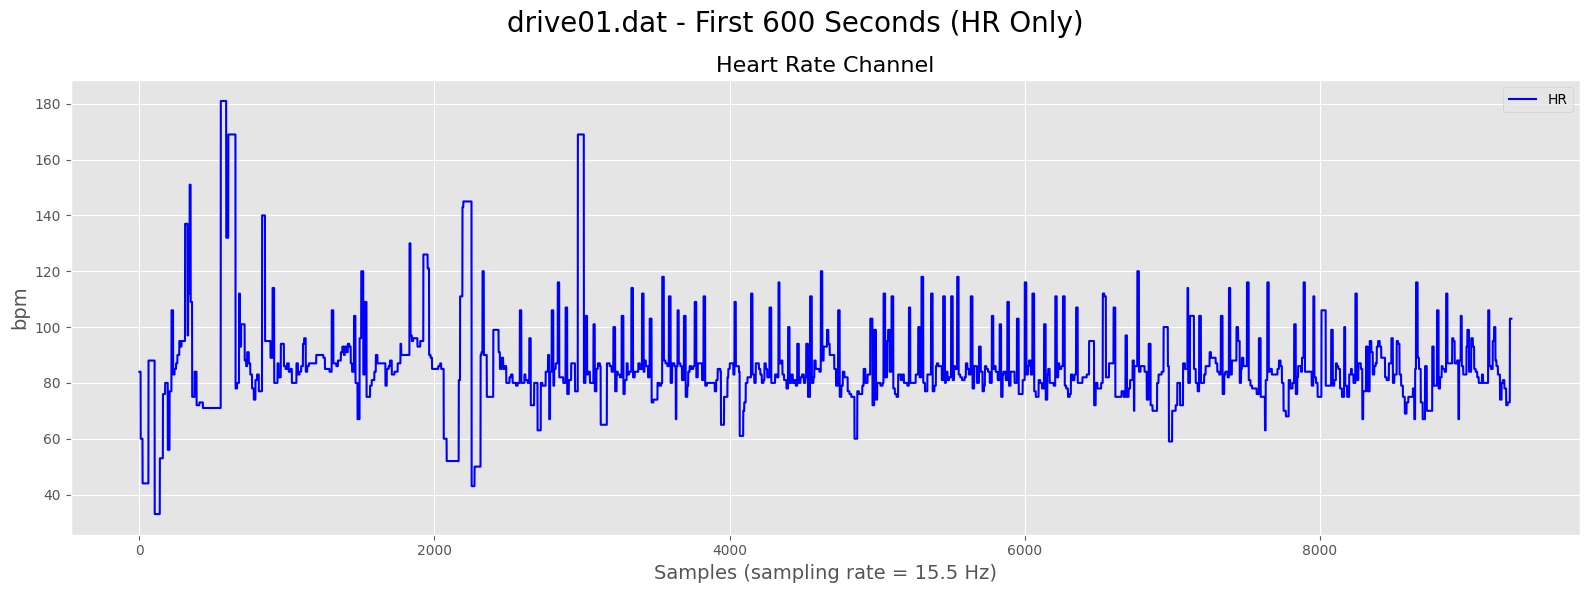

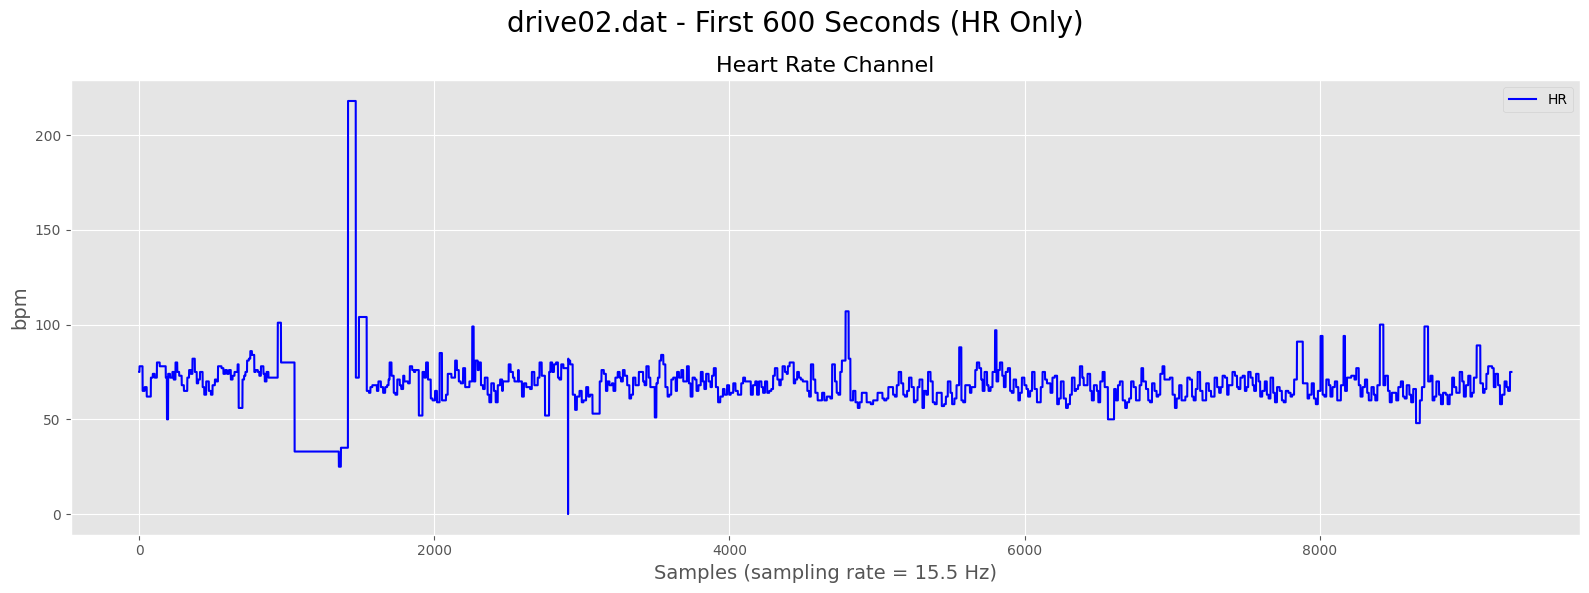

Skipping drive03.dat because no 'HR' channel was found.


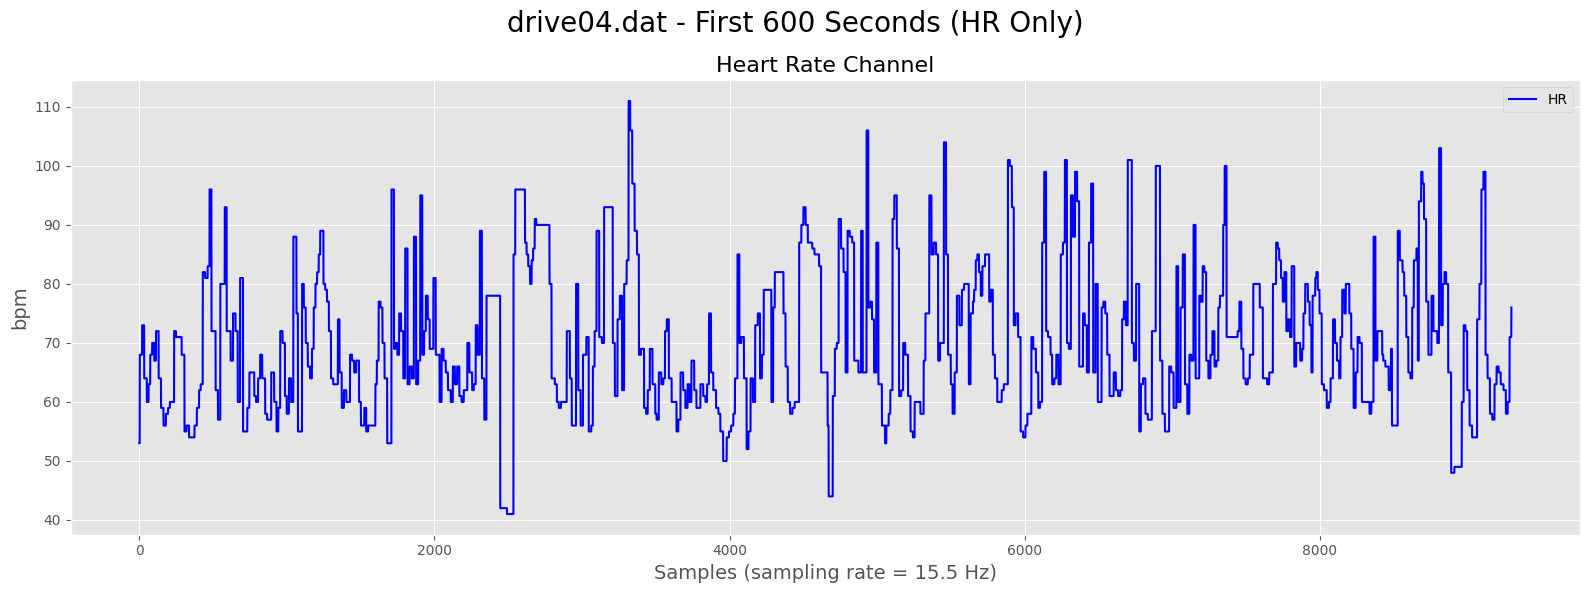

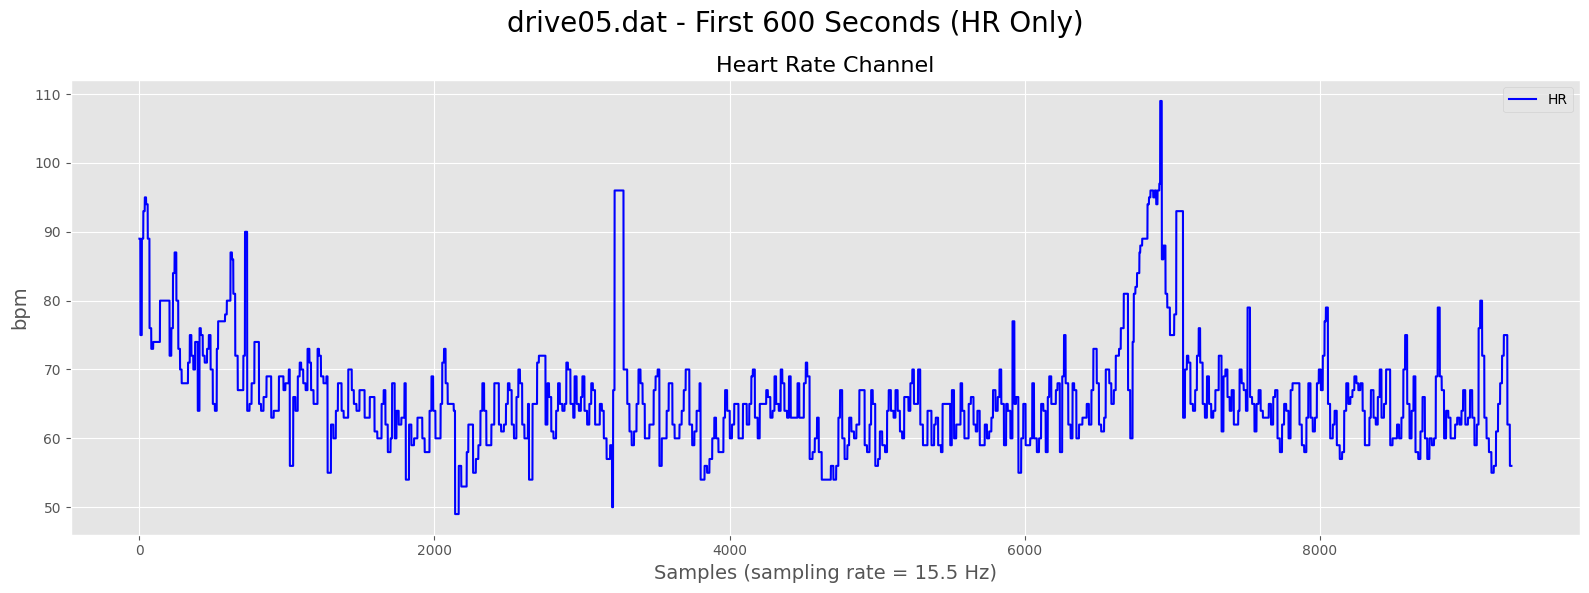

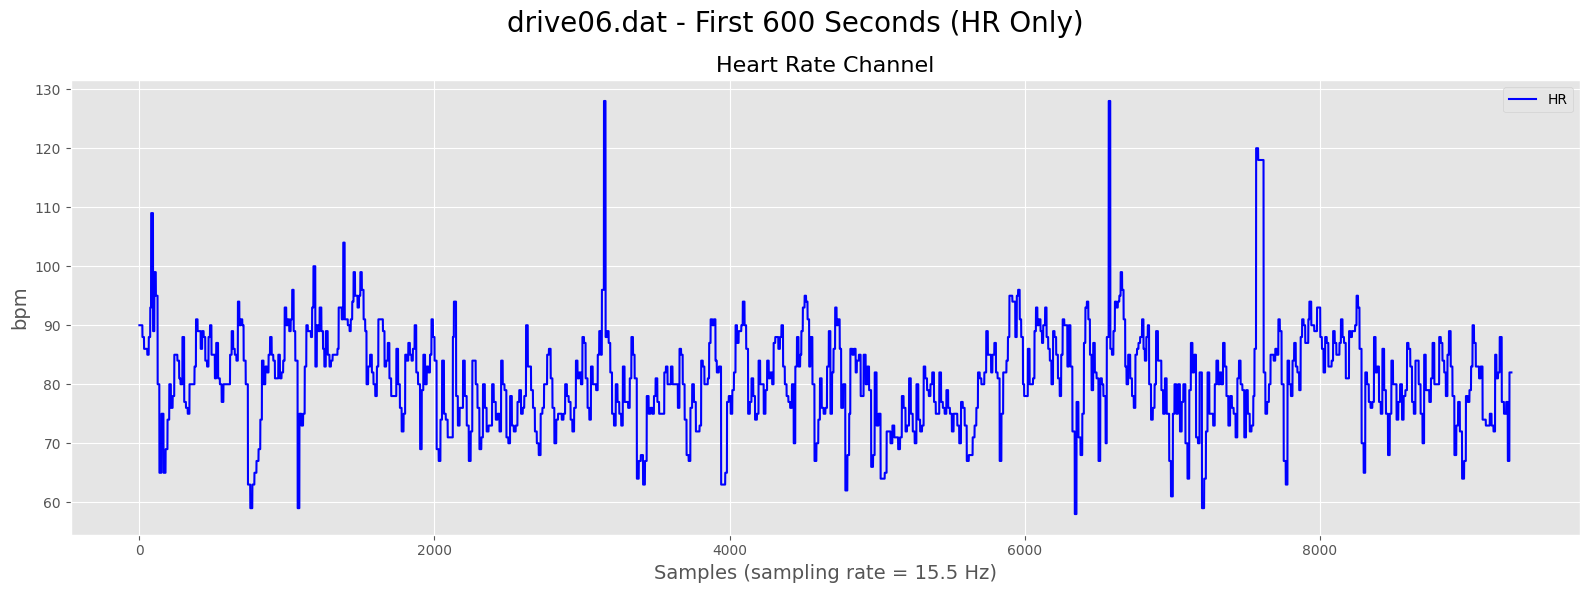

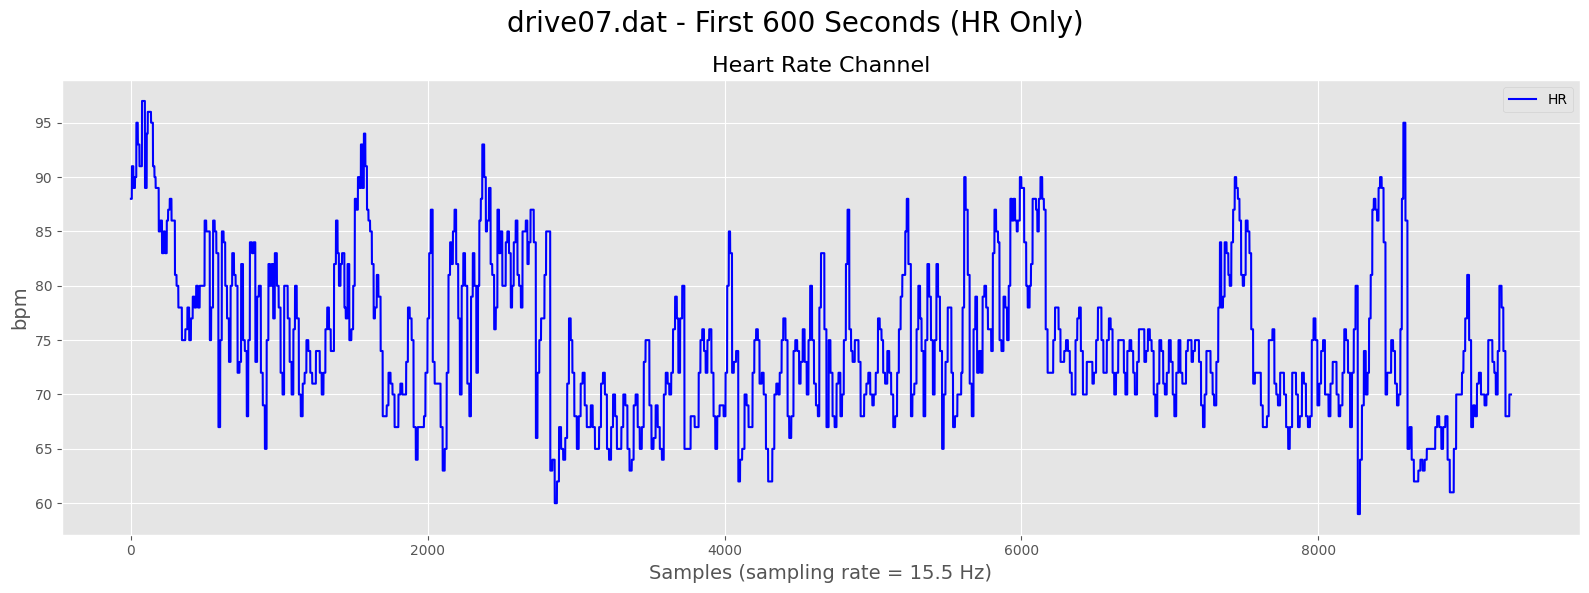

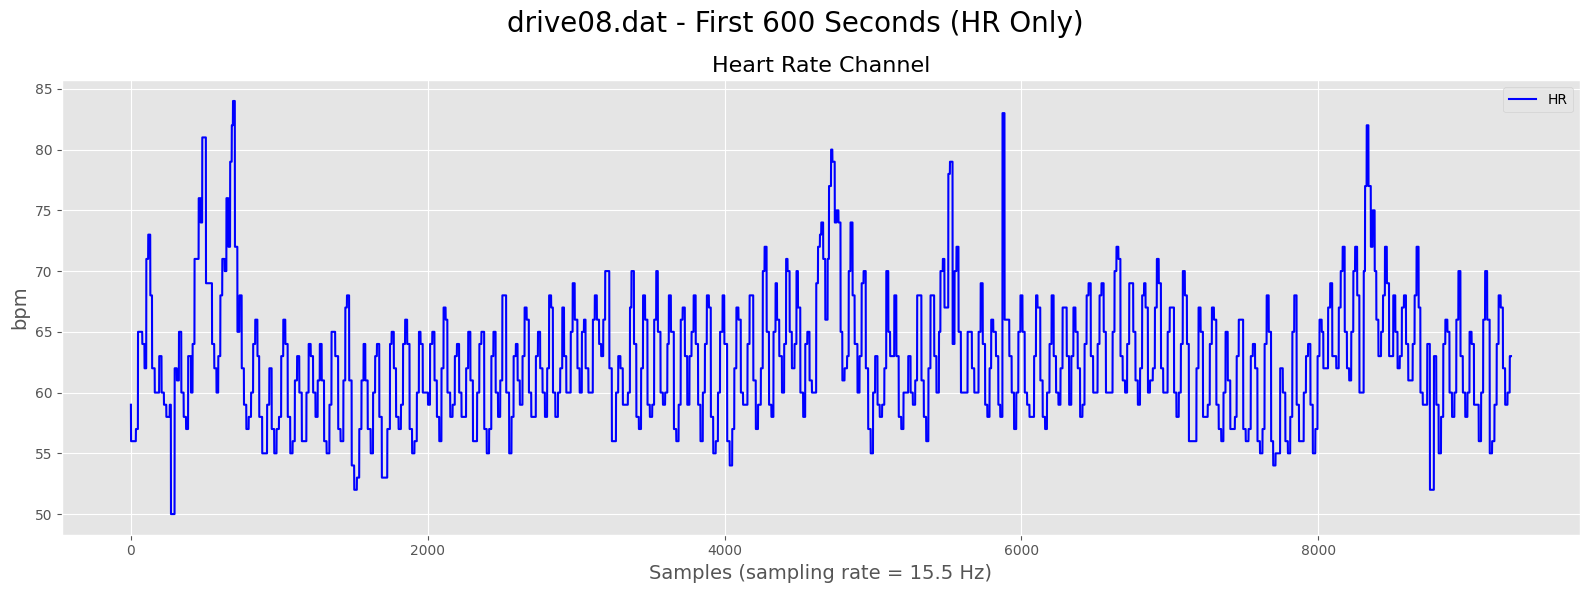

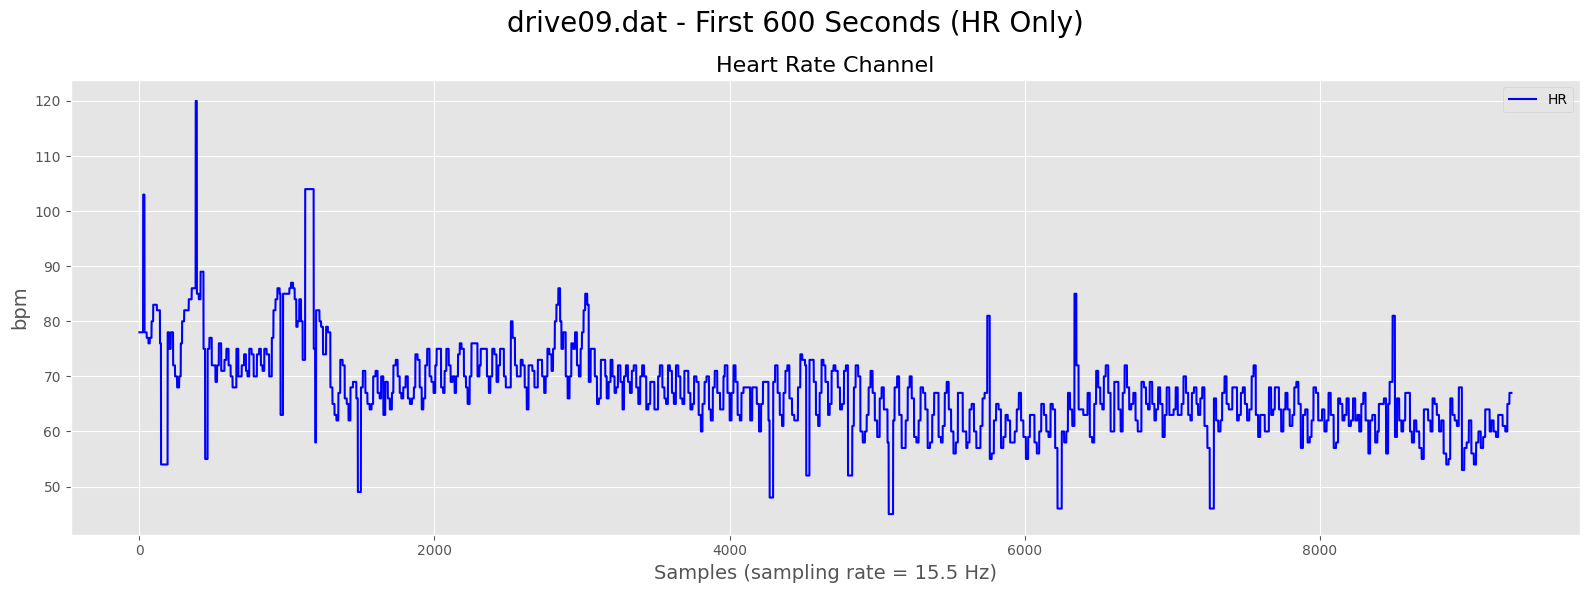

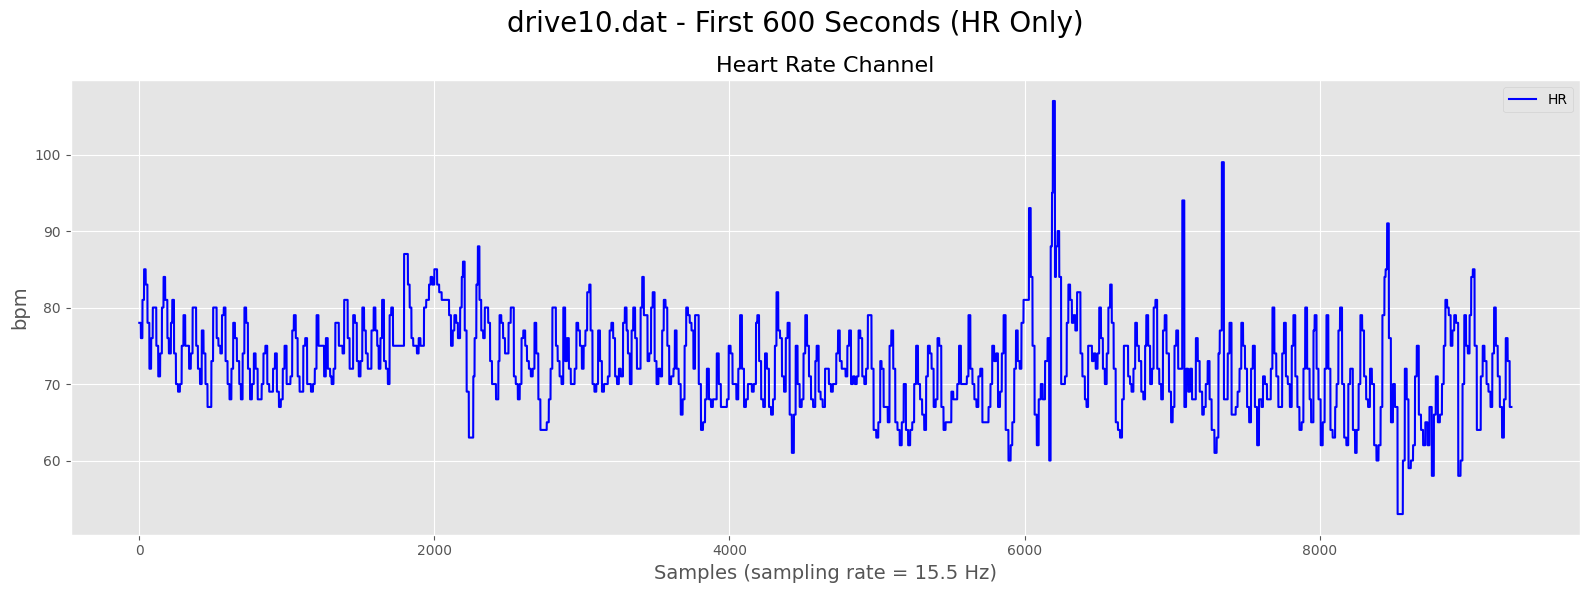

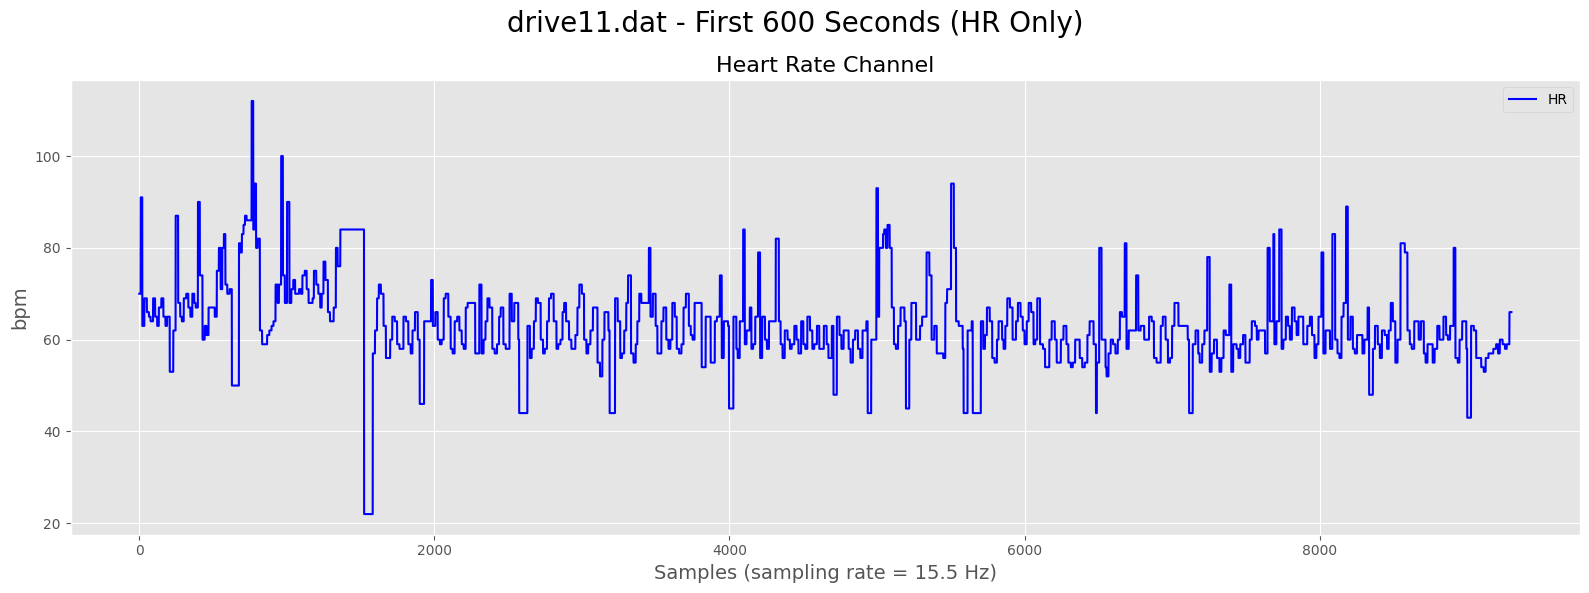

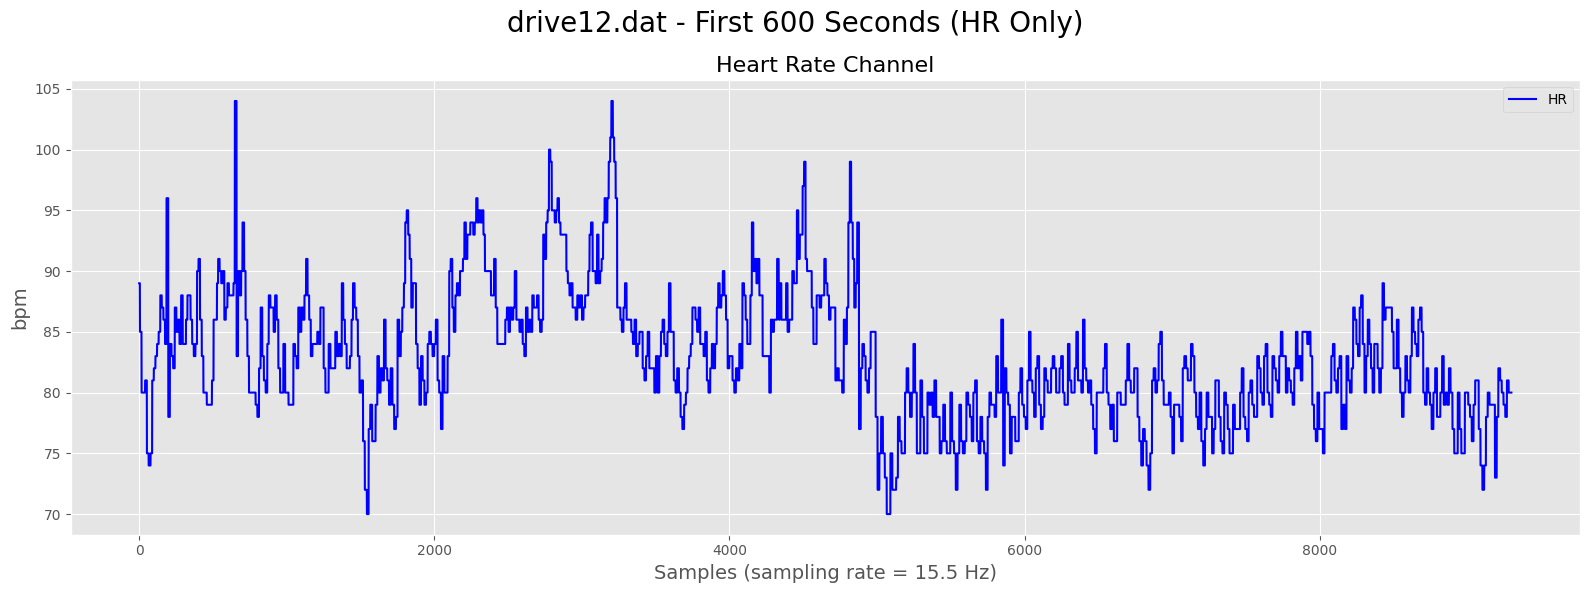

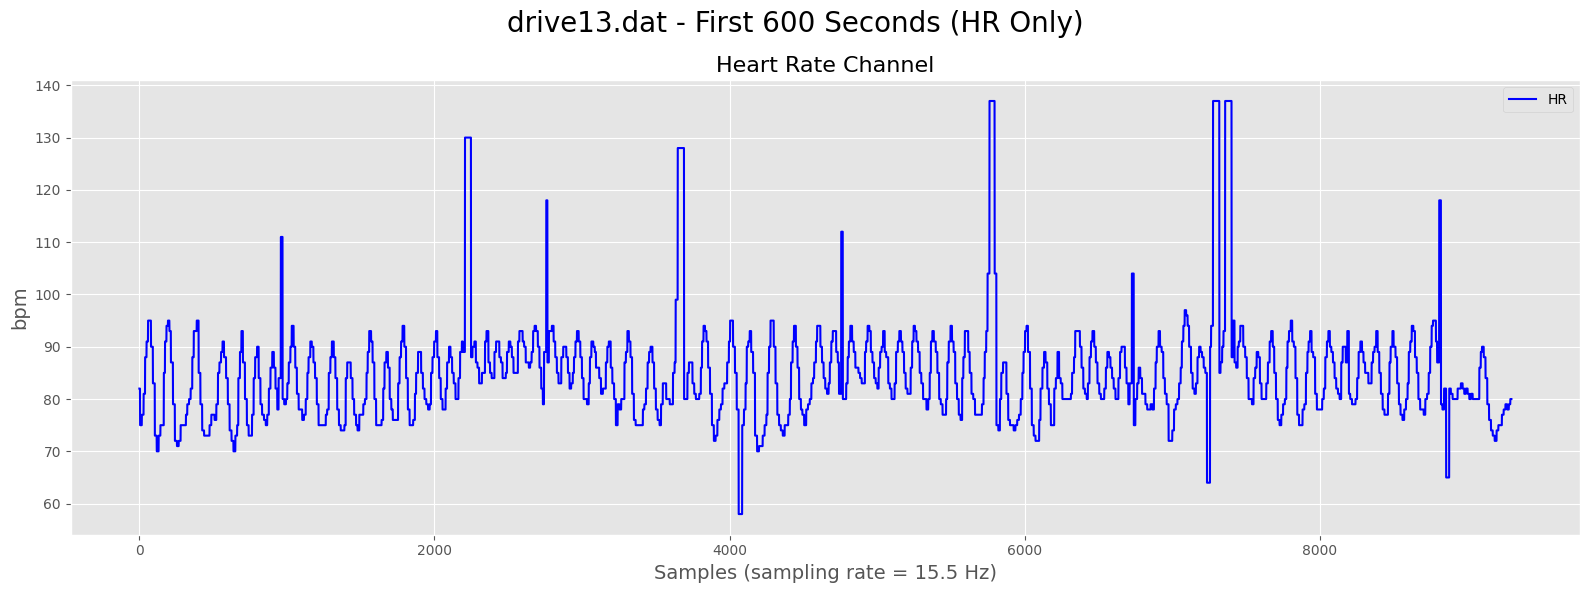

Skipping drive14.dat because no 'HR' channel was found.


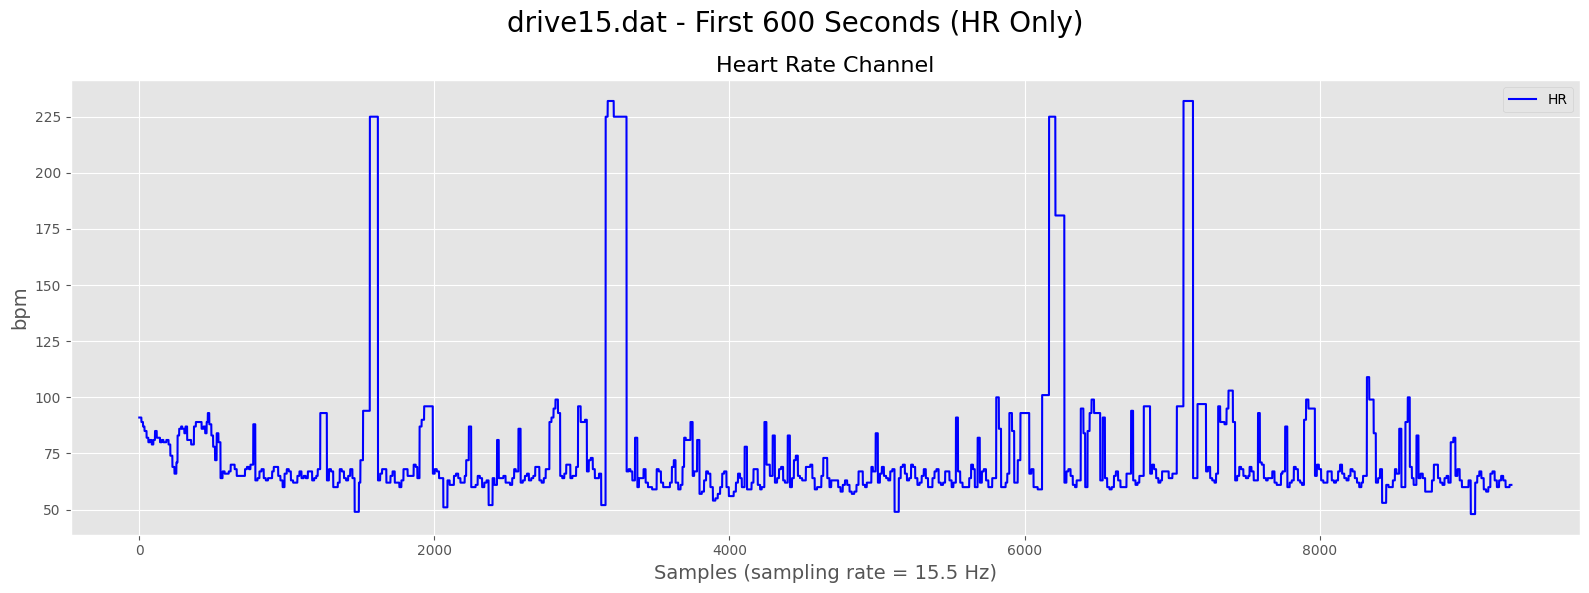

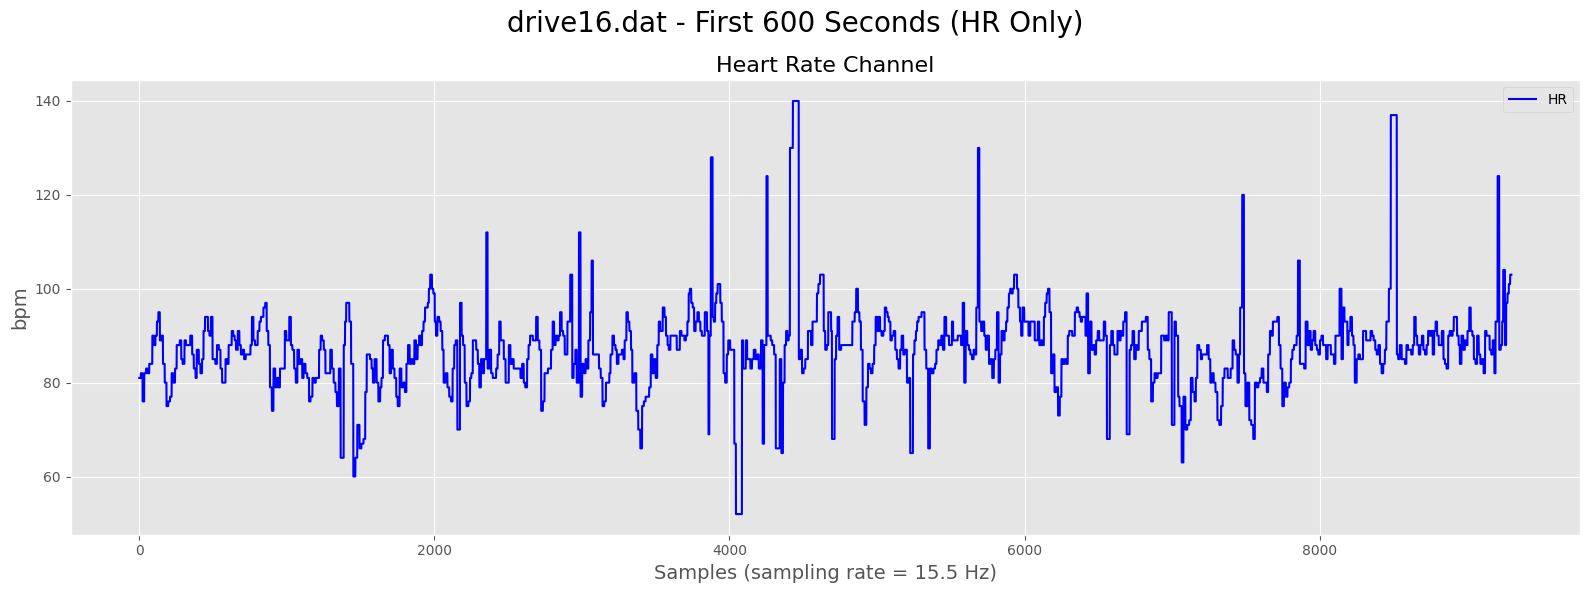

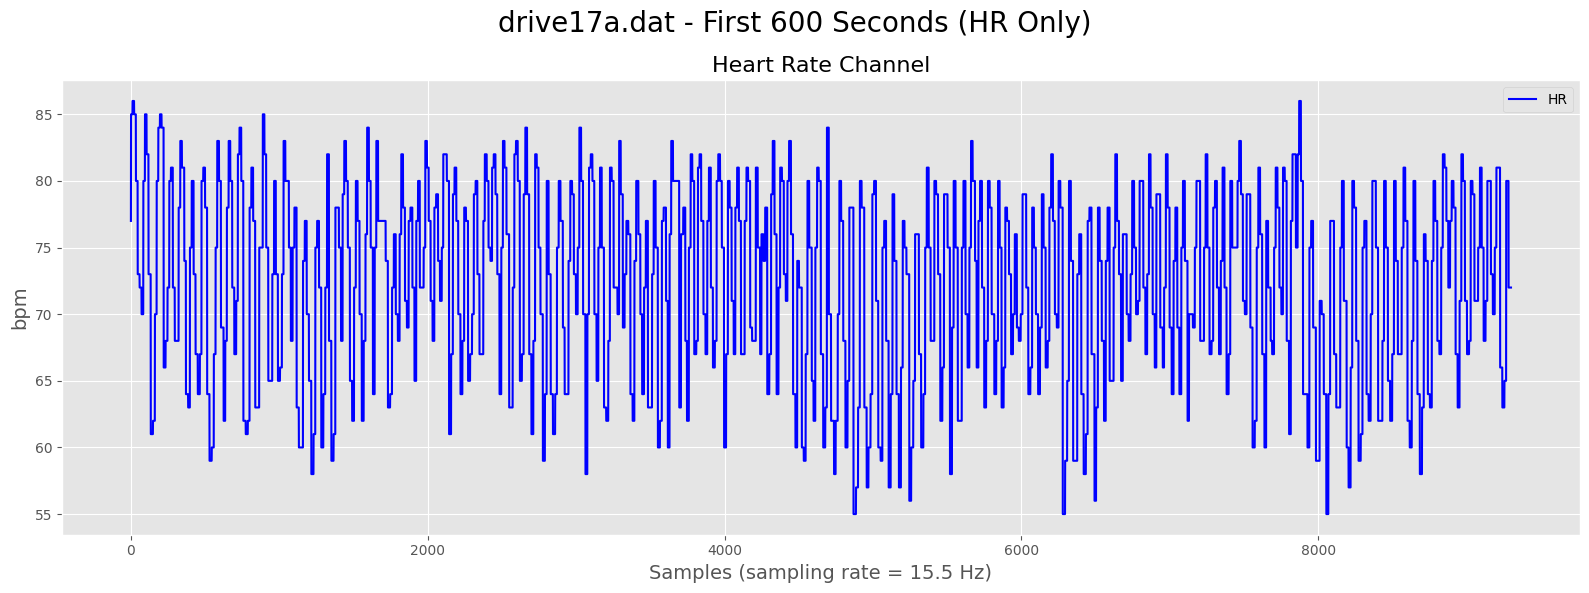

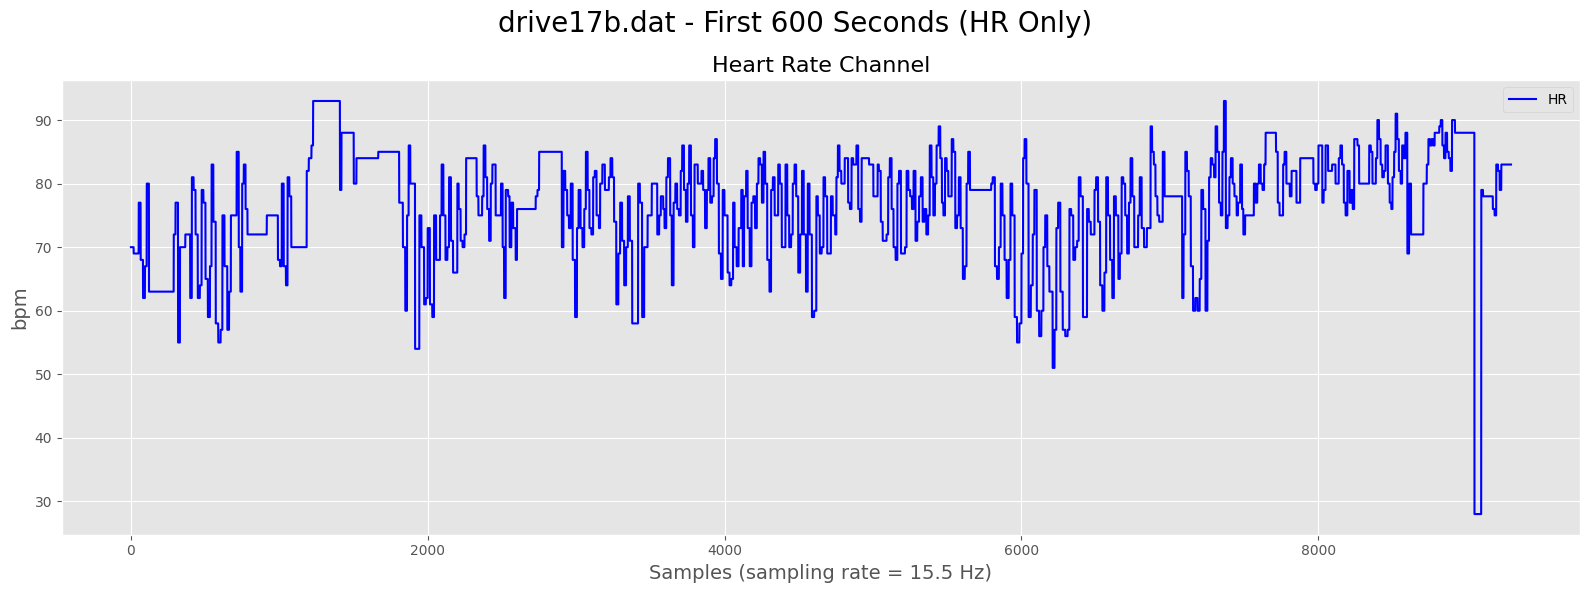

In [29]:
data_dir = "/kaggle/input/stress-recognition-in-automobile-drivers/physionet.org/files/drivedb/1.0.0/"
files = [f for f in os.listdir(data_dir) if f.endswith(".dat")]
files.sort()

# Sampling rate and total seconds to plot
fs = 15.5
duration_seconds = 600

if not files:
    raise FileNotFoundError("No .dat files found in the directory.")

for file in files:
    # Read data (WFDB)
    file_path = os.path.join(data_dir, os.path.splitext(file)[0])
    signals, fields = wfdb.rdsamp(file_path)
    signal_names = fields['sig_name']
    
    # Check if this file has an "HR" channel
    if "HR" not in signal_names:
        print(f"Skipping {file} because no 'HR' channel was found.")
        continue
    
    hr_index = signal_names.index("HR")
    hr_signal = signals[:, hr_index]
    
    # Determine how many samples correspond to the requested duration
    samples_to_plot = int(fs * duration_seconds)
    if samples_to_plot > len(hr_signal):
        samples_to_plot = len(hr_signal)
    
    # Create a figure for this driver's HR signal
    plt.figure(figsize=(16, 6))
    plt.suptitle(f"{file} - First {duration_seconds} Seconds (HR Only)", fontsize=20)
    
    hr_unit = fields['units'][hr_index] if 'units' in fields else "HR Value"
    
    # Plot only the specified duration
    plt.plot(hr_signal[:samples_to_plot], color='blue', label='HR')
    
    plt.xlabel(f"Samples (sampling rate = {fs} Hz)", fontsize=14)
    plt.ylabel(hr_unit, fontsize=14)
    plt.title("Heart Rate Channel", fontsize=16)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
